In [1]:
from data_augmentor import data_augment, batchify

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

from time import sleep
from sklearn.model_selection import train_test_split

In [2]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    print('using cuda...')
    device = torch.device("cuda")     
else:
    print('using cpu...')
    device = torch.device("cpu")

using cpu...


In [3]:
CACHE_FOLDER_PATH = "/Users/aref/dvs-dataset/Cached/"
DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/DvsGesture/"
    
nb_image_height = 64
nb_image_weight = 64
nb_inputs  = nb_image_height*nb_image_weight
nb_hidden  = 100
nb_outputs = 12

time_step = 1e-3
nb_steps  = 100

batch_size = 32

In [4]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [5]:
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print('init')

init


In [6]:
class SuperSpike(torch.autograd.Function):
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SuperSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SuperSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SuperSpike.apply

In [15]:
def run_snn(inputs):
    print inputs.shape, 'vs', w1.shape
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = [mem]
    spk_rec = [mem]

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c   = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]

        new_syn = alpha*syn +h1[:,t]
        new_mem = beta*mem +syn -rst

        mem = new_mem
        syn = new_syn

        mem_rec.append(mem)
        spk_rec.append(out)

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [22]:
def train(lr=2e-3, nb_epochs=10):
    params = [w1,w2]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in batchify('train',
                                         DATASET_FOLDER_PATH,
                                         CACHE_FOLDER_PATH,
                                         condition_limit=['natural']):
            x_local = np.reshape(x_local, (16, 100, 64*64))
            x_local = torch.from_numpy(x_local).type(dtype)
            y_local = torch.from_numpy(y_local.astype(np.long))
            
#             print '>>>>>', x_local.shape, y_local.shape
#             print y_local

            output,_ = run_snn(x_local)
            m,_=torch.max(output,1)
            log_p_y = log_softmax_fn(m)
            loss_val = loss_fn(log_p_y, y_local)

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
        mean_loss = np.mean(local_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        loss_hist.append(mean_loss)
        
    return loss_hist

In [23]:
loss_hist = train(lr=2e-4, nb_epochs=15)

torch.Size([16, 100, 4096]) vs torch.Size([4096, 100])


RuntimeError: The size of tensor a (32) must match the size of tensor b (16) at non-singleton dimension 0

In [12]:
%matplotlib inline
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

NameError: name 'loss_hist' is not defined

<Figure size 495x300 with 0 Axes>

In [13]:
def compute_classification_accuracy(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    max_count = len(x_data) / batch_size
    for counter in range(max_count):
        i = counter*batch_size
        x_local = torch.from_numpy(x_data[i:i+batch_size, :, :]).type(dtype)
        y_local = torch.from_numpy(y_data[i:i+batch_size])
        output, _ = run_snn(x_local)
        m, _ = torch.max(output,1) # max over time
        _, am = torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local.type(torch.long)==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)


print("Training accuracy: %.3f"%(compute_classification_accuracy(x_train, y_train)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test,y_test)))

NameError: name 'x_train' is not defined

In [14]:
def plot_voltage_traces(mem, spk=None, dim=(1,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = (mem+spike_height*spk).detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

def get_mini_batch(x_data, y_data, shuffle=False):
    max_count = x_data.shape[0] / batch_size
    for counter in range(max_count):
        i = counter*batch_size
        x_local = x_data[i:i+batch_size, :, :]
        y_local = y_data[i:i+batch_size]
        return x_local, y_local

x_batch, y_batch = get_mini_batch(x_train, y_train)
output, other_recordings = run_snn(torch.from_numpy(x_batch).type(dtype))
mem_rec, spk_rec = other_recordings

fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

NameError: name 'x_train' is not defined

In [15]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

NameError: name 'output' is not defined

<Figure size 600x400 with 0 Axes>

NameError: name 'spk_rec' is not defined

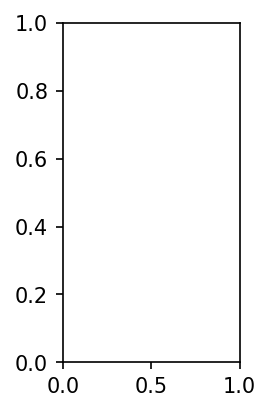

In [16]:
# Let's plot the hiddden layer spiking activity for some input stimuli

nb_plt = 4
gs = GridSpec(1,nb_plt)
fig= plt.figure(figsize=(7,3),dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
    if i==0:
        plt.xlabel("Time")
        plt.ylabel("Units")

    sns.despine()